In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import log_loss

from models import make_voting_ensemble
from predict import preprocess_data
from os.path import join as pj
from tqdm import tqdm_notebook
import pandas as pd

datadir = '/Volumes/4TB/numerai/117/'
train_df = pd.read_csv(pj(datadir, 'numerai_training_data.csv'))
tourn_df = pd.read_csv(pj(datadir, 'numerai_tournament_data.csv'))
(X, y, eras), _ = preprocess_data(train_df, tourn_df, target='bernie')
ueras = unique(eras)
K = len(ueras)
era_masks = {era: eras==era for era in ueras}

In [2]:
Cs = geomspace(1e-6, 1e6, 13)
parallel = joblib.Parallel(n_jobs=-1, verbose=0)

def logistic_whitened(C=1):
    return Pipeline([
        ('scaler', StandardScaler()),
        ('logistic', LogisticRegression(
            C=C, tol=1e-4, max_iter=1000, warm_start=True))])

def train_and_predict(train_era):
    model = logistic_whitened()
    train_mask = era_masks[train_era]
    X_train, y_train = X[train_mask], y[train_mask]
    probs = empty((len(X), len(Cs)))
    for j, C in enumerate(Cs):
        model.set_params(logistic__C=C)
        model.fit(X_train, y_train)
        p = model.predict_proba(X)[:, 1]
        p[train_mask] = nan
        probs[:, j] = p
    return probs

probs = array(parallel(joblib.delayed(train_and_predict)(train_era)
    for train_era in tqdm_notebook(ueras)))

In [8]:
random.seed(420)
memory = {}

def evaluate(sample):
    tsamp = tuple(sample)
    if tsamp in memory:
        return memory[tsamp]
    p = [probs[i, :, j] for i, j in enumerate(sample)]
    p = nanmean(p, axis=0)
    loss = log_loss(y, p)
    memory[tsamp] = loss
    return loss

def reproduce(parents, num_children, mutate_prob):
    children = array([parents[0] for _ in range(num_children)])
    for ind in where(parents[0] != parents[1])[0]:
        children[:, ind] = random.choice(parents[:, ind], size=num_children)
    mutate_mask = random.binomial(1, mutate_prob, size=children.shape).astype(bool)
    if mutate_mask.sum():
        children[mutate_mask] = random.randint(len(Cs), size=mutate_mask.sum())
    if len(set(map(tuple, children)).union(set(map(tuple, parents)))) < num_children + 2:
        return reproduce(parents, num_children, mutate_prob)
    return children
    
def genetic_search(population_size=10, num_children=2, generations=100, mutate_prob=1e-3):
    population = random.randint(len(Cs), size=(population_size, K)).tolist()
    min_loss = [(0, inf)]
    for generation in tqdm_notebook(range(generations)):
        loss = array([evaluate(i) for i in population])
        if loss.min() < min_loss[-1][1]:
            min_loss.append((generation, loss.min()))
            print(min_loss[-1][1])
        fitness = loss.max() - loss
        fitness /= fitness.max()
        fitness /= fitness.sum()
        parent_inds = random.choice(population_size, size=2, p=fitness, replace=False)
        parents = array(population)[parent_inds]
        while all(parents[0]==parents[1]):
            parent_inds = random.choice(population_size, size=2, p=fitness, replace=False)
            parents = array(population)[parent_inds]
        children = reproduce(parents, num_children, mutate_prob)
        population += children.tolist()
        population.pop(argmin(fitness))
        population_size += num_children - 1
    return population[argmin(loss)], min_loss

winner, losses = genetic_search(
    population_size=10, 
    num_children=1, 
    generations=50000, 
    mutate_prob=.01
)


0.6927386458476685
0.692738363642428
0.6927326925727535
0.6926995438640468
0.6926973492163729
0.6926868689460637
0.6926837668640977
0.6926787755850393
0.6926756317297222
0.6926750344036685
0.6926740198357124
0.6926736062247609
0.6926732545042633
0.6926723310943643
0.6926723297337173
0.6926720973269361
0.6926683795324361
0.6926673801335216
0.692665983598525
0.6926634893088748
0.6926621948885123
0.692657014101522
0.6926551568959648
0.6926526059257165
0.692650184709264
0.6926482140250876
0.6926480726978331
0.6926469931999293
0.6926450715688012
0.6926383104657658
0.692637794420803
0.6926371644853954
0.6926361966230156
0.6926333632165103
0.6926327433678696
0.6926326800347823
0.692632679420045
0.6926320617917585
0.6926315868674042
0.6926309320166741
0.6926285480519566
0.692627607763348
0.6926208967899403
0.6926207840224365
0.692618290030672
0.6926171548437521
0.6926168404919707
0.6926143856250041
0.6926112051607323
0.6926107463061965
0.6926066215859057
0.6926051099691097
0.6926042200590059


0.6924572219540681
0.6924570886648226
0.6924570886644978
0.6924570792784578
0.6924570792781413
0.6924570792729164
0.6924570439141556
0.6924570253693648
0.6924570238061164
0.6924570238060849
0.6924570237656076
0.6924569792863016
0.6924569792805821
0.6924569792719941
0.6924569792704423
0.6924569792691114
0.6924569791178045
0.692456978874444
0.6924569788735236
0.6924569619741593
0.6924569619533166
0.6924569619523965
0.6924569591693298
0.6924569591684087
0.6924569514846504
0.692456951484424
0.6924569514597825
0.692456949815852
0.6924569498155618



In [14]:
gens, losses = zip(*losses)

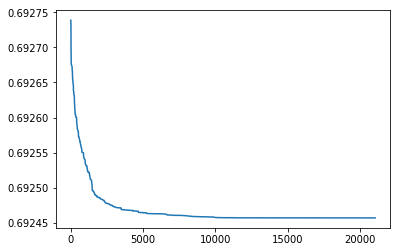

In [20]:
plot(gens, losses)

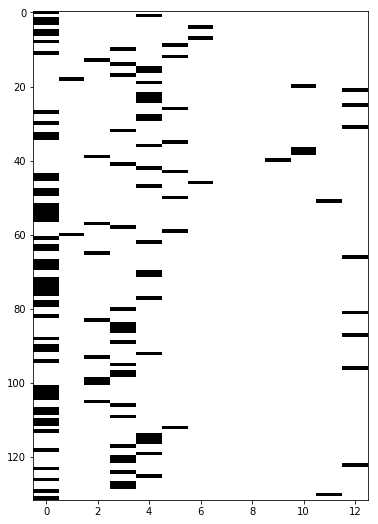

In [13]:
figure(figsize=(6, 9))
imshow(eye(len(Cs))[winner], cmap='gray_r', aspect='auto')

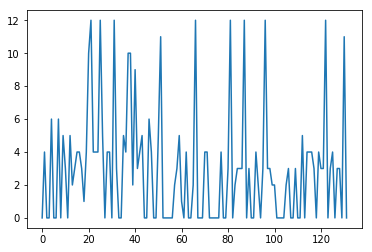

In [22]:
plot(winner)

In [6]:
learners = [
    logistic_whitened(C=Cs[winner[i]]
    ).fit(X[era_masks[era]], y[era_masks[era]])
for i, era in enumerate(tqdm_notebook(ueras))]

In [ ]:
from mlxtend.classifier import EnsembleVoteClassifier
ensemble = EnsembleVoteClassifier(learners, refit=False, voting='soft').fit([[0], [1]], [0, 1])